# Lunar Lander trained with Deep Q Network

## Step 0: Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
import random
import cv2

## Step 1: Activate the environment and examine state/action spaces

In [2]:
env = gym.make('LunarLander-v2')

In [3]:
print(env.observation_space.shape)
print(env.action_space)

(8,)
Discrete(4)


In [4]:
state_size = env.observation_space.shape
action_size = env.action_space.n

Let's take some random actions in the environment and see what happens...

In [5]:
scores = []
for i_episode in range(5):
    score = 0
    observation = env.reset()
    t = 0
    while(True):
        t += 1
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        score += reward
        if done:
            print("Episode finished after {0} timesteps with a score of {1}".format(t+1, score))
            break
    scores.append(score)
env.close()

Episode finished after 94 timesteps with a score of -127.13601472725658
Episode finished after 84 timesteps with a score of -230.92401366205857
Episode finished after 82 timesteps with a score of -129.62369561260348
Episode finished after 116 timesteps with a score of -146.12661852046404
Episode finished after 98 timesteps with a score of -407.37594535383624


## Step 2: Create and train the agent

In [6]:
from agent import DQN
from collections import deque

In [7]:
# Define all hyperparameters here
LR = 1e-3
RANDOM_SEED = 42
BUFFER_SIZE = 1e5
BATCH_SIZE = 64
GAMMA = 0.995
TAU = 1e-3
N_TIME_STEPS = 1
N_LEARN_UPDATES = 1
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995

if tf.test.is_gpu_available():
    DEVICE = "/GPU:0"
else:
    DEVICE = "/device:CPU:0"

In [8]:
agent = DQN(state_size, action_size, LR,
            RANDOM_SEED, BUFFER_SIZE, BATCH_SIZE,
            GAMMA, TAU, N_TIME_STEPS, N_LEARN_UPDATES, DEVICE) # Instantiate the agent


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode 100	Average Score: -154.59
Episode 200	Average Score: -53.535
Episode 300	Average Score: -65.64
Episode 400	Average Score: 86.908
Episode 500	Average Score: 163.47
Episode 538	Average Score: 202.42
High score so stopping training in 438 episodes!	Average Score: 202.42


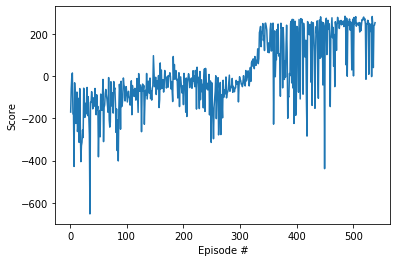

In [9]:
def dqn(n_episodes=50000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    eps = EPS_START
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        
        score = 0
        t = 0
        
        while(True):
            t += 1
            
            action = agent.act(state, eps)
            
            next_state, reward, done, _ = env.step(action)
            
            agent.step(t, state, action, reward, next_state, done)
            
            state = next_state.copy()
            
            score += reward
            
            if done:
                break
                
        scores_deque.append(score)
        scores.append(score)
        
        # Reduce exploration rate because we are more sure of our actions now
        if eps > EPS_END:
            eps *= EPS_DECAY
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        agent.q_local.model.save('checkpoint_q_network.h5')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            agent.q_local.model.save('checkpoint_q_network.h5')
            break
            
    return scores

scores = dqn()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 3: See the trained agent in action

In [10]:
from tensorflow.keras.models import load_model

trained_model = load_model('checkpoint_q_network.h5', compile=False)

In [11]:
for i_episode in range(5):
    next_state = env.reset()
    
    score = 0.0
    
    t = 0
    while(True):
        t += 1
        env.render()
        
        next_state = np.expand_dims(next_state, axis=0)
        
        action = np.argmax(trained_model(next_state).numpy()[0])
        
        next_state, reward, done, info = env.step(action)
        
        score += reward
        if done:
            break
    
    print("Episode {0} finished after {1} timesteps. Total score: {2}".format(i_episode+1, t+1, score))
            
env.close()

Episode 1 finished after 154 timesteps. Total score: 79.42793176171824
Episode 2 finished after 234 timesteps. Total score: -1.9720285098181023
Episode 3 finished after 334 timesteps. Total score: 277.93766368211203
Episode 4 finished after 203 timesteps. Total score: -11.573341626143417
Episode 5 finished after 332 timesteps. Total score: 257.58081102933465
